## Llibreries

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree


## EDA (Exploratory Data Analysis)

Primer llegim el csv de les dades i les guardem. En aquest cas, totes les dades es troben només en un únic csv.

In [10]:
dataset = pd.read_csv('data/Pokemon.csv')

In [11]:
dataset.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Com podem veure, la primera columna no ens aporta gens d'informació rellevant per fer la classificació.

In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


Es pot observar que quasi bé tots els atributs son del tipus int64. També cal veure que del type2, només hi han 414 valors, per  tant hi han 386 valors perduts.

In [17]:
dataset.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

Podem veure que només el atribut Type 2 té valors nulls. Però aquest atribut no el tindrem en compte alhora de fer la nostra classificació de llegendari. Primer eliminem les columnes no necessàries que son: #, name, type 1 i type2, i fem l'estudi sobre les altres. 

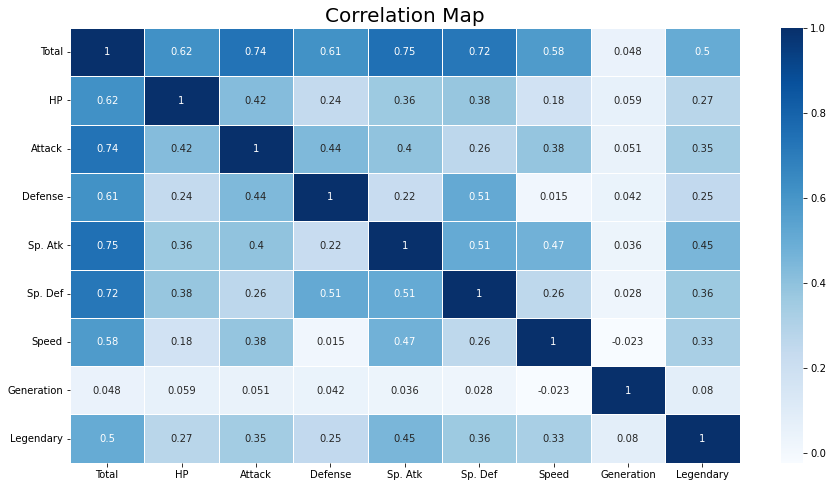

In [21]:
plt.rcParams['figure.figsize']=(15,8)
heat_map = sns.heatmap(dataset[['Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary']].corr(), annot = True, linewidths=1, cmap='Blues')
heat_map.set_title(label='Correlation Map', fontsize=20)
heat_map;

In [23]:
dataset.drop('#', axis=1, inplace=True)
dataset.drop('Name', axis=1, inplace=True)
dataset.drop('Type 1', axis=1, inplace=True)
dataset.drop('Type 2', axis=1, inplace=True)

In [32]:
dataset['Legendary'] = dataset['Legendary'].astype(int)

Transformem el boleà de Lengendary a 0 i 1.

In [33]:
dataset.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,318,45,49,49,65,65,45,1,0
1,405,60,62,63,80,80,60,1,0
2,525,80,82,83,100,100,80,1,0
3,625,80,100,123,122,120,80,1,0
4,309,39,52,43,60,50,65,1,0


Eliminem del dataset les columnes que no volem per fer l'estudi de si un Pokemon és o no llegendari.

Mostrem la quantitat de mostres en el dataset que tenen valor 1 a Legendary

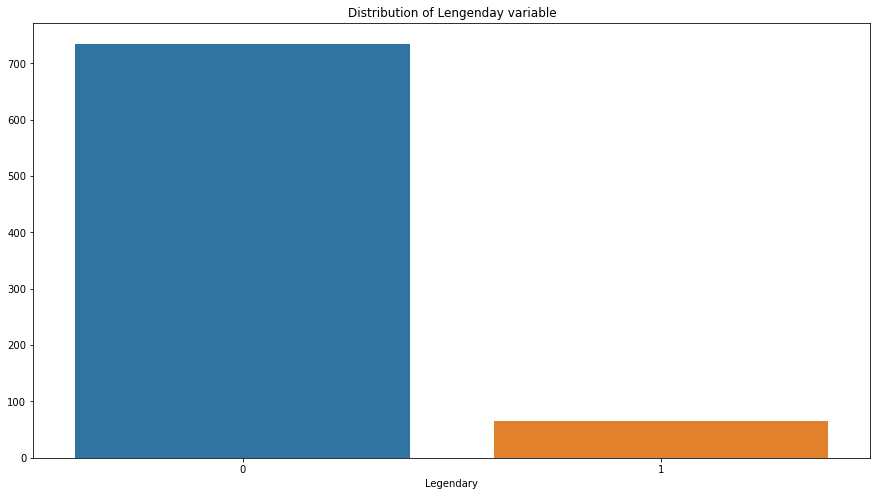

In [36]:
sns.barplot(data=dataset['Legendary'].value_counts().reset_index(), x='index', y='Legendary')
plt.xlabel('Legendary')
plt.ylabel('')
plt.title('Distribution of Lengenday variable')
plt.show()

## Model selection

Primer de tot separem les nostres dades en train i test. Utilitzaré la distribució de 80% train i 20% test